<a href="https://colab.research.google.com/github/muhammadmo/BloodCell-AI-Diagnosis/blob/main/microscopic_peripheral_blood_cell_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadmoosavi","key":"1fa1bc8aae4bfd517b860f44615ff8d9"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d unclesamulus/blood-cells-image-dataset

Dataset URL: https://www.kaggle.com/datasets/unclesamulus/blood-cells-image-dataset
License(s): CC-BY-SA-4.0
 75% 200M/268M [00:00<00:00, 748MB/s] 
100% 268M/268M [00:00<00:00, 506MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "blood-cells-image-dataset.zip"

with ZipFile(file_name,'r') as zipp:
  zipp.extractall()
print('done')

done


In [ ]:
pip install split_folders

In [ ]:
!pip install tensorflow==2.7.0

ERROR: Could not find a version that satisfies the requirement tensorflow==2.7.0 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==2.7.0


In [ ]:
!sudo apt-get install python3.9

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3.9 is already the newest version (3.9.23-1+jammy1).
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [ ]:
!python3.7 -m venv py37env
!source py37env/bin/activate

Error: Command '['/content/py37env/bin/python3.7', '-Im', 'ensurepip', '--upgrade', '--default-pip']' returned non-zero exit status 1.
/bin/bash: line 1: py37env/bin/activate: No such file or directory


In [ ]:
import splitfolders
input_folder = "/content/bloodcells_dataset"
output = "/content/splited_dataset"

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.7, .1, .2))

Copying files: 17092 files [00:02, 6308.63 files/s]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

train_path = '/content/splited_dataset/train'
test_path = '/content/splited_dataset/test'
valid_path = '/content/splited_dataset/val'

#set defult image size
batch_size = 16
img_width = 299
img_height = 299

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                rotation_range=15,
                                width_shift_range=0.05,
                                height_shift_range=0.05,
                                rescale = 1./255,
                                shear_range = 0.2,
                                zoom_range = 0.2,
                                horizontal_flip = True,
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='rgb',
      class_mode='sparse',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='rgb',
      shuffle=False,
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem
      class_mode='sparse',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='rgb',
      class_mode='sparse',
      batch_size=batch_size
      )

Found 11959 images belonging to 8 classes.
Found 3428 images belonging to 8 classes.
Found 1705 images belonging to 8 classes.


In [ ]:
from tensorflow.keras.applications import ResNet101V2

conv_base = ResNet101V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

conv_base.summary()

171317808/171317808 [==============================] - 1s 0us/step
Model: "resnet101v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                     

In [ ]:
from keras import models
from keras import layers
from tensorflow import keras
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop

optimizer = keras.optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)

model = models.Sequential()

model.add(Conv2D(3, (3, 3), padding="same", activation="relu", input_shape=(img_width, img_height, 1)))

model.add(conv_base)

model.add(GlobalAveragePooling2D())

model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(8,activation="softmax"))
model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

conv_base.trainable = False
model.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 3)       30        
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                        

In [ ]:
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

#early stopping
early = EarlyStopping(monitor="val_loss",
                      mode="auto",
                      patience=9)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 4, verbose=1,factor=1e-1, min_lr=0.000001)

checkpoint_filepath1 = 'checkpointCNN2.h5'
Model_check1 = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath1, monitor='val_loss', verbose=1, save_best_only=False, mode='auto')

callbacks_list = [ early, learning_rate_reduction]

In [ ]:
history = model.fit(train,
                    batch_size=16,
                    epochs=10,
                    validation_data=valid,
                    callbacks=[early,learning_rate_reduction, Model_check, Model_check1])

NameError: name 'model' is not defined

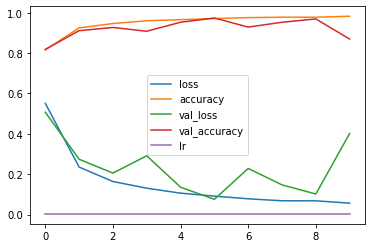

In [ ]:
pd.DataFrame(model.history.history).plot()

In [ ]:
test_accu = model.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')
preds = model.predict(test,verbose=1)

215/215 [==============================] - 20s 91ms/step - loss: 0.4226 - accuracy: 0.8635
The testing accuracy is : 86.34772300720215 %
215/215 [==============================] - 20s 84ms/step


In [ ]:
import numpy as np
rounded_labels=np.argmax(preds, axis=1)
rounded_labels[1]

0

In [ ]:
from sklearn.metrics import confusion_matrix
cmm = confusion_matrix(rounded_labels, test.classes)
cmm

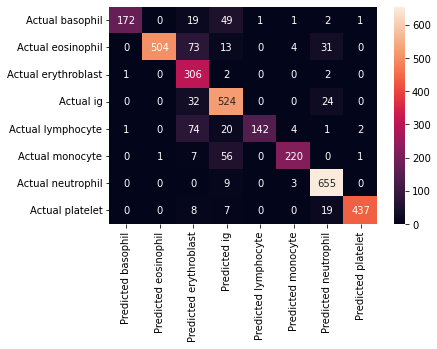

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, rounded_labels, labels=[0, 1, 2, 3, 4, 5, 6, 7]),index=["Actual basophil", "Actual eosinophil", "Actual erythroblast", "Actual ig", "Actual lymphocyte", "Actual monocyte", "Actual neutrophil", "Actual platelet"],
columns=["Predicted basophil", "Predicted eosinophil", "Predicted erythroblast", "Predicted ig", "Predicted lymphocyte", "Predicted monocyte", "Predicted neutrophil", "Predicted platelet"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")